In [62]:
import pandas as pd
import numpy as np
import timeit
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
#import plotly.graph_objs as go
%matplotlib inline

In [2]:
from pandas_datareader import data as pdr

/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
date_end = dt.datetime.today()
date_start = date_end - dt.timedelta(30)

## Web scraping S&P100 companies from Wikipedia table

In [4]:
import requests
website_url = requests.get("https://en.wikipedia.org/wiki/S%26P_100").text

from bs4 import BeautifulSoup
soup = BeautifulSoup(website_url,'lxml')
#print(soup.prettify())

In [5]:
wiki_table = soup.find('table',{'class':'wikitable sortable'})

wiki_table_data = wiki_table.tbody.find_all("tr")


# Get all the headings of Lists
headings = []
for th in wiki_table_data[0].find_all("th"):
    # remove any newlines and extra spaces from left and right
    headings.append(th.text.replace('\n', ' ').strip())

print(headings)


In [6]:
data = []
tHeader = []
SP100_tickers = pd.DataFrame()

for tr in wiki_table.find_all("tr"):
    for th in tr.find_all("th")[:1]:
        tHeader = th.get_text(strip=True)
        SP100_tickers[tHeader] = []
    for td in tr.find_all("td")[:1]:
        data.append( td.get_text(strip=True))
        
SP100_tickers[tHeader] = data

In [7]:
SP100_tickers

,Symbol
0,AAPL
1,ABBV
2,ABT
3,ACN
4,ADBE
...,...
96,VZ
97,WBA
98,WFC
99,WMT


# Use DataReader to get financial data of S&P100 companies from yahoo

In [8]:
%%time

df = pd.DataFrame()

for i in data:
    symbol = SP100_tickers.loc[SP100_tickers['Symbol']==i]
    try:
        symbol_data = pdr.DataReader(i, 'yahoo', date_start, date_end).reset_index()
        #display(symbol_data)  
    except: 
        print(i + " - Err")
        symbol_data = pd.DataFrame()
        pass
    single_table = pd.concat([symbol, symbol_data], axis=0, ignore_index=False)
    single_table['Symbol'].ffill(inplace=True)
    df = df.append(single_table)
    

BRK.B - Err
CPU times: user 9.02 s, sys: 678 ms, total: 9.7 s
Wall time: 3min 28s


In [9]:
df = df.loc[df['Date'].notnull()]

In [10]:
df = df.reset_index(drop=True)

df.groupby(['Symbol']).describe().transpose()

In [11]:
df_Org = df

# Manipulate table structure to graph

In [12]:
df = df.groupby(['Date', 'Symbol']).sum()

In [13]:
df

High         Low        Open       Close      Volume  \
Date       Symbol                                                               
2020-05-26 AAPL    324.239990  316.500000  323.500000  316.730011  31380500.0   
           ABBV     93.570000   90.309998   93.449997   90.709999  11869800.0   
           ABT      93.290001   89.169998   92.949997   89.480003   6243800.0   
           ACN     199.990005  196.029999  199.419998  196.399994   2408700.0   
           ADBE    391.269989  374.809998  391.000000  376.630005   3526000.0   
...                       ...         ...         ...         ...         ...   
2020-06-22 VZ       56.259998   55.610001   55.910000   55.999001   4727598.0   
           WBA      43.720001   42.759998   43.549999   43.150002   2651085.0   
           WFC      27.500000   26.889999   27.270000   27.378901  14708335.0   
           WMT     121.800003  120.400002  120.970001  121.434998   4643788.0   
           XOM      46.285000   45.410000   45.689999   46.055000   8171343.0   

                    Adj Close  
Date       Symbol              
2020-05-26 AAPL    316.730011  
           ABBV     90.709999  
           ABT      89.480003  
           ACN     196.399994  
           ADBE    376.630005  
...                       ...  
2020-06-22 VZ       55.999001  
           WBA      43.150002  
           WFC      27.378901  
           WMT     121.434998  
           XOM      46.055000  

[2000 rows x 6 columns]

In [14]:
df.unstack()

High                                                \
Symbol            AAPL       ABBV        ABT         ACN        ADBE   
Date                                                                   
2020-05-26  324.239990  93.570000  93.290001  199.990005  391.269989   
2020-05-27  318.709991  91.000000  90.779999  199.949997  375.700012   
2020-05-28  323.440002  91.190002  93.330002  204.179993  386.899994   
2020-05-29  321.149994  92.889999  95.589996  202.410004  389.049988   
2020-06-01  322.350006  93.059998  93.959999  203.750000  389.989990   
2020-06-02  323.440002  91.699997  93.150002  205.789993  390.910004   
2020-06-03  326.200012  91.500000  92.699997  207.830002  391.140015   
2020-06-04  325.619995  93.480003  91.339996  207.789993  395.720001   
2020-06-05  331.750000  95.540001  89.959999  209.720001  396.170013   
2020-06-08  333.600006  95.010002  92.610001  211.320007  398.100006   
2020-06-09  345.609985  96.660004  92.820000  209.789993  402.309998   
2020-06-10  354.769989  99.349998  92.750000  210.830002  409.980011   
2020-06-11  351.059998  96.889999  92.500000  205.949997  404.200012   
2020-06-12  347.799988  94.739998  90.190002  202.429993  411.720001   
2020-06-15  345.679993  94.029999  90.349998  200.740005  406.109985   
2020-06-16  353.200012  96.199997  91.760002  206.880005  414.679993   
2020-06-17  355.399994  97.099998  91.669998  206.330002  417.459991   
2020-06-18  353.450012  96.449997  91.339996  203.169998  420.839996   
2020-06-19  356.559998  98.199997  92.400002  208.289993  429.269989   
2020-06-22  357.410004  97.239998  90.650002  203.850006  436.190002   

                                                                        ...  \
Symbol            AIG         ALL        AMGN         AMT         AMZN  ...   
Date                                                                    ...   
2020-05-26  31.740000   98.120003  228.350006  248.679993  2462.000000  ...   
2020-05-27  32.959999   97.750000  225.130005  252.940002  2413.580078  ...   
2020-05-28  32.189999   99.309998  226.619995  259.470001  2436.969971  ...   
2020-05-29  31.040001   98.029999  230.570007  258.970001  2442.370117  ...   
2020-06-01  30.969999   99.589996  230.539993  266.779999  2476.929932  ...   
2020-06-02  31.760000   99.720001  226.360001  265.589996  2473.530029  ...   
2020-06-03  33.470001  100.910004  224.289993  269.250000  2488.000000  ...   
2020-06-04  35.220001  102.089996  223.449997  266.910004  2507.540039  ...   
2020-06-05  38.970001  106.599998  225.949997  265.910004  2488.649902  ...   
2020-06-08  39.509998  107.080002  226.250000  269.119995  2530.000000  ...   
2020-06-09  38.349998  105.879997  228.309998  267.079987  2626.429932  ...   
2020-06-10  37.299999  104.000000  229.490005  269.029999  2722.350098  ...   
2020-06-11  33.869999  100.230003  229.779999  263.589996  2671.379883  ...   
2020-06-12  33.580002   97.500000  222.350006  259.000000  2621.479980  ...   
2020-06-15  33.570000   98.410004  221.000000  263.079987  2584.000000  ...   
2020-06-16  35.500000  101.080002  228.880005  268.799988  2620.000000  ...   
2020-06-17  33.330002   99.650002  228.809998  268.399994  2655.000000  ...   
2020-06-18  33.000000   99.019997  231.479996  262.029999  2659.639893  ...   
2020-06-19  33.360001  101.000000  239.070007  265.869995  2697.429932  ...   
2020-06-22  31.775000   98.519997  237.639999  266.779999  2699.969971  ...   

             Adj Close                                                 \
Symbol             UNH         UNP         UPS        USB           V   
Date                                                                    
2020-05-26  293.625397  168.951981   97.070000  35.830002  193.220001   
2020-05-27  302.467285  172.869995   99.620003  37.619999  192.820007   
2020-05-28  302.666443  170.509995   99.720001  36.509998  194.259995   
2020-05-29  303.542664  169.860001   99.709999  35.560001  195.240005   
2020-06-01  304.618042  169.5000

df['Close'].unstack().plot(figsize=(10, 30))
plt.title("Close Price", fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Date', fontsize=14)
# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

# Track percent change to check performance of each company

df['Close'].unstack().pct_change().plot(figsize=(20, 10))
plt.title("% Changes in Close Price", fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Date', fontsize=14)
# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

# Pick 5 most volatile tickers

In [15]:
df_pct_change = df.unstack().pct_change()

In [16]:
df_pct_change

High                                                    \
Symbol          AAPL      ABBV       ABT       ACN      ADBE       AIG   
Date                                                                     
2020-05-26       NaN       NaN       NaN       NaN       NaN       NaN   
2020-05-27 -0.017055 -0.027466 -0.026905 -0.000200 -0.039793  0.038437   
2020-05-28  0.014841  0.002088  0.028090  0.021155  0.029811 -0.023362   
2020-05-29 -0.007080  0.018642  0.024215 -0.008669  0.005557 -0.035725   
2020-06-01  0.003737  0.001830 -0.017052  0.006620  0.002416 -0.002255   
2020-06-02  0.003381 -0.014614 -0.008621  0.010012  0.002359  0.025509   
2020-06-03  0.008533 -0.002181 -0.004831  0.009913  0.000588  0.053841   
2020-06-04 -0.001778  0.021639 -0.014671 -0.000193  0.011709  0.052286   
2020-06-05  0.018826  0.022037 -0.015108  0.009288  0.001137  0.106474   
2020-06-08  0.005577 -0.005547  0.029458  0.007629  0.004872  0.013857   
2020-06-09  0.036001  0.017367  0.002268 -0.007240  0.010575 -0.029360   
2020-06-10  0.026504  0.027829 -0.000754  0.004957  0.019065 -0.027379   
2020-06-11 -0.010457 -0.024761 -0.002695 -0.023147 -0.014098 -0.091957   
2020-06-12 -0.009286 -0.022190 -0.024973 -0.017092  0.018605 -0.008562   
2020-06-15 -0.006095 -0.007494  0.001774 -0.008349 -0.013626 -0.000298   
2020-06-16  0.021754  0.023078  0.015606  0.030587  0.021103  0.057492   
2020-06-17  0.006229  0.009356 -0.000981 -0.002659  0.006704 -0.061127   
2020-06-18 -0.005487 -0.006694 -0.003600 -0.015315  0.008097 -0.009901   
2020-06-19  0.008799  0.018144  0.011605  0.025201  0.020031  0.010909   
2020-06-22  0.002384 -0.009776 -0.018939 -0.021316  0.016120 -0.047512   

                                                    ... Adj Close            \
Symbol           ALL      AMGN       AMT      AMZN  ...       UNH       UNP   
Date                                                ...                       
2020-05-26       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2020-05-27 -0.003771 -0.014101  0.017130 -0.019667  ...  0.030113  0.023190   
2020-05-28  0.015959  0.006618  0.025816  0.009691  ...  0.000658 -0.013652   
2020-05-29 -0.012889  0.017430 -0.001927  0.002216  ...  0.002895 -0.003812   
2020-06-01  0.015913 -0.000130  0.030158  0.014150  ...  0.003543 -0.002119   
2020-06-02  0.001305 -0.018131 -0.004461 -0.001373  ...  0.001242  0.008496   
2020-06-03  0.011933 -0.009145  0.013781  0.005850  ... -0.003134  0.041594   
2020-06-04  0.011694 -0.003745 -0.008691  0.007854  ... -0.023809 -0.009099   
2020-06-05  0.044177  0.011188 -0.003747 -0.007533  ...  0.046196  0.047611   
2020-06-08  0.004503  0.001328  0.012072  0.016615  ... -0.007600 -0.017151   
2020-06-09 -0.011207  0.009105 -0.007580  0.038115  ... -0.000872 -0.019267   
2020-06-10 -0.017756  0.005168  0.007301  0.036521  ... -0.011190 -0.015323   
2020-06-11 -0.036250  0.001264 -0.020221 -0.018723  ... -0.072020 -0.069201   
2020-06-12 -0.027237 -0.032335 -0.017413 -0.018679  ...  0.005005  0.017699   
2020-06-15  0.009333 -0.006072  0.015753 -0.014297  ...  0.003963  0.010531   
2020-06-16  0.027131  0.035656  0.021742  0.013932  ...  0.023474  0.018103   
2020-06-17 -0.014147 -0.000306 -0.001488  0.013359  ... -0.001365  0.001170   
2020-06-18 -0.006322  0.011669 -0.023733  0.001748  ... -0.003828 -0.001869   
2020-06-19  0.019996  0.032789  0.014655  0.014209  ...  0.003480 -0.017559   
2020-06-22 -0.024554 -0.005982  0.003423  0.000942  ...  0.002369  0.003813   

                                                                        \
Symbol           UPS       USB         V        VZ       WBA       WFC   
Date                                                                     
2020-05-26       NaN       NaN       NaN       NaN       NaN       NaN   
2020-05-27  0.026270  0.049958 -0.002070  0.015470  0.019213  0.064356   
2020-05-28  0.001004 -0.029506  0.007468  0.010519 -0.026530 -0.026118   
2020-05-29 -0.000100 -0.026020  0.005045  0.029792 

In [17]:
df_pct_change.describe().transpose()

count      mean       std       min       25%       50%  \
          Symbol                                                            
High      AAPL     19.0  0.005228  0.013714 -0.017055 -0.005791  0.003737   
          ABBV     19.0  0.002173  0.017560 -0.027466 -0.008635  0.001830   
          ABT      19.0 -0.001375  0.016921 -0.026905 -0.014890 -0.002695   
          ACN      19.0  0.001115  0.015142 -0.023147 -0.008509 -0.000193   
          ADBE     19.0  0.005854  0.015721 -0.039793  0.001748  0.006704   
...                 ...       ...       ...       ...       ...       ...   
Adj Close VZ       19.0  0.001716  0.014028 -0.027884 -0.004351  0.004237   
          WBA      19.0  0.001649  0.029725 -0.079720 -0.013059  0.005774   
          WFC      19.0  0.003216  0.045856 -0.098283 -0.023413  0.008581   
          WMT      19.0 -0.000999  0.009283 -0.019569 -0.006960 -0.001566   
          XOM      19.0  0.000816  0.036869 -0.088253 -0.021161  0.006219   

                       75%       max  
          Symbol                      
High      AAPL    0.011820  0.036001  
          ABBV    0.018393  0.027829  
          ABT     0.006936  0.029458  
          ACN     0.009601  0.030587  
          ADBE    0.017363  0.029811  
...                    ...       ...  
Adj Close VZ      0.009803  0.029792  
          WBA     0.017582  0.051215  
          WFC     0.046014  0.064356  
          WMT     0.002940  0.015764  
          XOM     0.021847  0.081059  

[600 rows x 8 columns]

In [18]:
Top5_volatile_tickers = df_pct_change['Close'].describe().transpose().sort_values(by='std', ascending=False).head(5)

In [19]:
Top5_volatile_tickers.index

Index(['OXY', 'SPG', 'BA', 'C', 'F'], dtype='object', name='Symbol')

In [20]:
Top5_volatile_tickers_untacked = df['Close'].unstack().pct_change()[Top5_volatile_tickers.index]
Top5_volatile_tickers_untacked

Symbol,OXY,SPG,BA,C,F
Date,,,,,
2020-05-26,NaN,NaN,NaN,NaN,NaN
2020-05-27,0.001389,0.066498,0.033096,0.084908,0.032534
2020-05-28,-0.054092,-0.054439,0.002006,-0.059319,-0.029851
2020-05-29,-0.050587,-0.034310,-0.026498,-0.025427,-0.023932
2020-06-01,0.066409,0.067591,0.037984,0.032144,0.028021
2020-06-02,0.068067,0.030033,0.012682,0.028109,0.005111
2020-06-03,0.047458,0.148621,0.129476,0.049174,0.049153
2020-06-04,0.006473,0.052827,0.064334,0.043307,0.061389
2020-06-05,0.336978,0.154698,0.114650,0.057682,0.117199


In [66]:
with PdfPages('best_performed_5'+ str(dt.datetime.now())+'.pdf') as pdf:

    Top5_volatile_tickers_untacked.plot(figsize=(20, 10))
    plt.title("Most volatiled", fontsize=16)
    # Define the labels for x-axis and y-axis
    plt.ylabel('Price', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    # Plot the grid lines
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
    #plt.show()
    pdf.savefig()
    plt.close()

In [22]:
Top5_best_performing_tickers = df_pct_change['Close'].describe().transpose().sort_values(by='mean', ascending=False).head(5)

In [23]:
Top5_best_performing_tickers

,count,mean,std,min,25%,50%,75%,max
Symbol,,,,,,,,
OXY,19.0,0.021917,0.106668,-0.161368,-0.050293,0.006473,0.063850,0.336978
BA,19.0,0.015566,0.073846,-0.164250,-0.026472,0.007546,0.051159,0.129476
SPG,19.0,0.009344,0.076420,-0.133598,-0.045497,0.000596,0.061475,0.154698
ADBE,19.0,0.007925,0.019654,-0.047072,-0.001445,0.012420,0.018180,0.048675
PYPL,19.0,0.007659,0.020095,-0.042962,-0.003802,0.014506,0.019416,0.041804


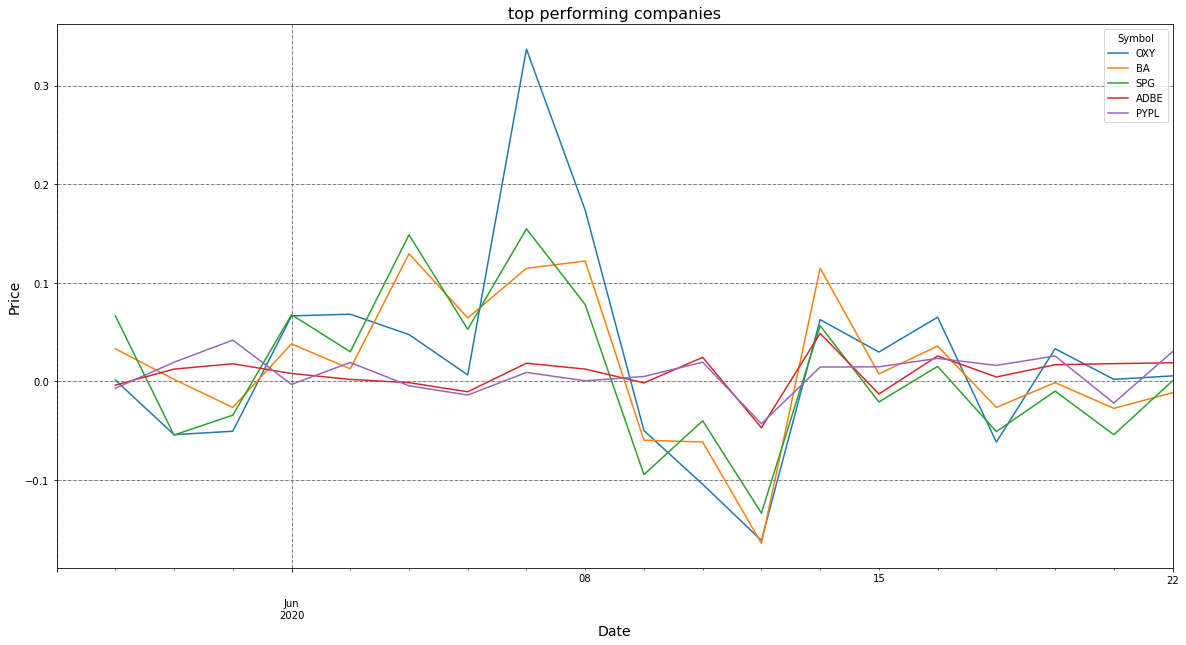

In [60]:
(df['Close'].unstack().pct_change()[Top5_best_performing_tickers.index]).plot(figsize=(20, 10))
plt.title("top performing companies", fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Date', fontsize=14)
# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
x = plt.show()

In [27]:
from fpdf import FPDF
pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", size = 12)

In [28]:
col_width = pdf.w / 4.5
row_height = pdf.font_size

# Forecasting closing prices using Tensorflow

In [30]:
from sklearn.preprocessing import MinMaxScaler

In [31]:
scaler = MinMaxScaler()
scale_cols = df[['Close', 'Volume']]
df_scaled = scaler.fit_transform(scale_cols)
df_scaled = pd.DataFrame(df_scaled)

In [32]:
df_scaled.columns = ['Close', 'Volume']

In [33]:
df_scaled

,Close,Volume
0,0.116072,0.149999
1,0.031722,0.056445
2,0.031263,0.029468
3,0.071165,0.011079
4,0.138427,0.016436
...,...,...
1995,0.018738,0.014052
1996,0.013879,0.008288
1997,0.008009,0.048432
1998,0.043250,0.015733


In [79]:
train = df_scaled[:50]
test = df_scaled[-50:]

In [80]:
display(train), display(test)

,Close,Volume
0,0.116072,0.149999
1,0.031722,0.056445
2,0.031263,0.029468
3,0.071165,0.011079
4,0.138427,0.016436
5,0.009442,0.039622
6,0.032968,0.012747
7,0.080868,0.011027
8,0.088903,0.013116
9,0.901703,0.016639


,Close,Volume
1950,0.020078,0.020493
1951,0.051012,0.006175
1952,0.033950,0.022850
1953,0.010203,0.010704
1954,0.003620,0.011163
1955,0.014917,0.015206
1956,0.057435,0.001995
1957,0.136803,0.001283
1958,0.047598,0.002882
1959,0.110444,0.004345


(None, None)

In [83]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [90]:
feature_cols = 'Volume'
label_cols = 'Close'

train_feature = train[feature_cols]
train_label = train[label_cols]

test_feature = test[feature_cols]
test_label = test[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20 )

In [91]:
train_feature.shape, train_label.shape

((30, 20), (30,))

In [92]:


# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape
# ((6086, 20, 4), (1522, 20, 4))

# test dataset 
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape
# ((180, 20, 4), (180, 1))

((30, 20), (30,))

In [94]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[1]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [96]:
import os

In [98]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
#filename = os.path.join(model_path, 'tmp_checkpoint.h5')
#checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

NameError: name 'checkpoint' is not defined